# Construct Inputs from Reanalysis products
* This iteration takes a lat/lon box and reanalysis product to force with. For now will be RYF so that Angus' code still applies. 
* Also takes bathymetry and generates a hgrid based on user input and the bathy. Everything then interpolated onto this hgrid like before. 
* This notebook should be a testbed, then all the bits for constructing the domain turned into functions

In [55]:
import netCDF4
import xarray as xr
import xesmf as xe
from itertools import cycle
import os
import dask
import numpy as np
import pandas as pd
import dask.array as da
import dask.bag as db
from pykdtree.kdtree import KDTree
from dask.diagnostics import ProgressBar
import subprocess

import matplotlib.pyplot as plt
import motuclient
os.chdir("cosima_regional/mom6-regional-scripts")
print(os.getcwd())
import datetime as dt

# Import scripts
from regional_model_scripts import input_datasets, interp_segment,prepare_segments, time_rotate,regrid_runoff,sel_hgrid_indices
from boundary_tides import write_tpxo

om2inputdir = "/g/data/ik11/inputs/access-om2/input_08022019/mom_01deg/" ## Access om2_01 input for topography and hgrid
initinputdir = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077" ## Access om2_01 output for BCs and IC
toolinputdir = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables
    
xr.set_options(keep_attrs=True) ## This ensures that performing simple operations with xarray (eg converting temperature to Celsius) preserves attributes

from dask.distributed import Client
client = Client()
client

FileNotFoundError: [Errno 2] No such file or directory: 'cosima_regional/mom6-regional-scripts'

In [ ]:

## Choose your coordinates and the name of your experiment
yextent = [-48,-38.95]
xextent = [-217 , -210]
expt_name = "reanalysis-small"

pwd = "$KQ%QqFxjSSbE2"
usr = "abarnes"


daterange = ["2015-01-01 00:00:00", "2015-01-31 00:00:00"]


## Place where all your input files go
inputdir = f"/scratch/v45/ab8992/mom6/regional_configs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/mom6_rundirs/{expt_name}/"

## Directory where raw downloads go before processing
tmpdir = f"/scratch/v45/ab8992/reanalysis_tmp/{expt_name}/"

for i in [inputdir,rundir,tmpdir]:
    try:
        os.mkdir(i)
    except:
        pass

if "temp" not in os.listdir(inputdir):
    os.mkdir(inputdir + "temp")
if "weights" not in os.listdir(inputdir):
    os.mkdir(inputdir + "weights")
if "forcing" not in os.listdir(inputdir):
    os.mkdir(inputdir + "forcing")

    


## Firstly, generate a bash request that downloads the IC anc BC from the GLORYs reanalysis product 

In [ ]:
import regional_model_scripts as ml 


file = open(f"{tmpdir}/get_oceanfiles.sh","w")
file.write(
        moturequests(xextent, yextent, daterange, tmpdir, usr, pwd,["north","south","east","west"])
)
file.close()

ml.motu_requests(xextent, yextent, daterange, tmpdir, usr, pwd,["north","south","east","west"])


"#!/bin/bash\n\n\nprintf 'processing north segment' \npython -m motuclient --motu https://my.cmems-du.eu/motu-web/Motu --service-id GLOBAL_MULTIYEAR_PHY_001_030-TDS --product-id cmems_mod_glo_phy_my_0.083_P1D-m --longitude-min -217 --longitude-max -210 --latitude-min -39.25 --latitude-max -38.650000000000006 --date-min 2015-01-01 00:00:00 --date-max 2015-01-31 00:00:00 --depth-min 0.49 --depth-max 6000 --variable so --variable thetao --variable vo --variable zos --variable uo --out-dir /scratch/v45/ab8992/reanalysis_tmp/reanalysis-small --out-name north_segment_unprocessed --user 'abarnes' --pwd '$KQ%QqFxjSSbE2' & \n\nprintf 'processing south segment' \npython -m motuclient --motu https://my.cmems-du.eu/motu-web/Motu --service-id GLOBAL_MULTIYEAR_PHY_001_030-TDS --product-id cmems_mod_glo_phy_my_0.083_P1D-m --longitude-min -217 --longitude-max -210 --latitude-min -48.3 --latitude-max -47.7 --date-min 2015-01-01 00:00:00 --date-max 2015-01-31 00:00:00 --depth-min 0.49 --depth-max 6000 -

## Read in our saved boundary segments

In [ ]:
north = xr.open_dataset("/scratch/v45/ab8992/reanalysis_tmp/reanalysis-small/north_segment_unprocessed",decode_times=False)
north

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 8, time: 31, longitude: 85)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 -39.25 -39.17 -39.08 ... -38.83 -38.75 -38.67
  * time       (time) float64 5.698e+05 5.698e+05 ... 5.705e+05 5.705e+05
  * longitude  (longitude) float32 143.0 143.1 143.2 143.2 ... 149.8 149.9 150.0
Data variables:
    vo         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
Attributes: (12/25)
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2022/05/25 21:54:07 MERCATOR OCEAN Ne...
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    ...                                 ...
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              5727.917
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

## Make a class for each boundary segment. 
* Requires inputdir to raw segment, the hgrid, the segment cardinal direction and names of variables
* Has a re-written brushcutter function as a method. Might still need to save a zarr file, but chunking should be easier given rectangular slices 
* Overarching function should take care of the hgrid and initial condition?

In [ ]:
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables

def dz(npoints,ratio,target_depth,min_dz = 0.0001,invert = False,tolerence = 1):
    """
    Recursive function takes the target depth, the ratio between largest and smallest layer thicknesses, and generates a hyperbolic tangent thickness profile for the experiment.
    Iterates to find the mininum depth value which gives the target depth within some tolerence

            Parameters:
                npoints (int):           Number of vertical points
                ratio (float):           Ratio of largest to smallest layer thickness. Negative values mean higher resolution is at bottom
                target_depth (float):    Maximum depth of a layer
                min_dz (float):          Starting point for iteration
                tolerence (float):       How close to target depth you want to get

            Returns:
                numpy array of layer thicknesses

    """
    profile = min_dz + 0.5 *  (np.abs(ratio) * min_dz - min_dz) * (1 + np.tanh(2 * np.pi * (np.arange(npoints) - npoints // 2) / npoints))
    tot = np.sum(profile)
    if np.abs(tot - target_depth) < tolerence:
        if ratio > 0:
            return profile

        return profile[::-1]

    err_ratio = target_depth / tot

    return dz(npoints,ratio,target_depth,min_dz * err_ratio)

class experiment:
    """
    Knows everything about your regional experiment! Methods in this class will generate the various input files you need to generate a MOM6 experiment forced with Open Boundary Conditions. It's written agnostic to your choice of boundary forcing,topography and surface forcing - you need to tell it what your variables are all called via mapping dictionaries where keys are mom6 variable / coordinate names, and entries are what they're called in your dataset. 
    """

    def __init__(self, xextent,yextent,resolution,vlayers,dz_ratio,depth,mom_run_dir,mom_input_dir,toolpath):
        self.xextent = xextent
        self.yextent = yextent
        self.res = resolution
        self.vlayers = vlayers
        self.dz_ratio = dz_ratio
        self.depth = depth
        self.mom_run_dir = mom_run_dir
        self.mom_input_dir = mom_input_dir
        self.toolpath = toolpath
        self.hgrid = self._make_hgrid()
        self.vgrid = self._make_vgrid()
        # if "temp" not in os.listdir(inputdir):
        #     os.mkdir(inputdir + "temp")

        

        if "weights" not in os.listdir(self.mom_input_dir):
            os.mkdir(inputdir + "weights")
        if "forcing" not in os.listdir(self.mom_input_dir):
            os.mkdir(self.mom_input_dir + "forcing")

        # create a simlink from input directory to run directory and vv
        subprocess.run(f"ln -s {self.mom_input_dir} {self.mom_run_dir}/inputdir",shell=True)
        subprocess.run(f"ln -s {self.mom_run_dir} {self.mom_input_dir}/rundir",shell=True)
        
        return 
    
    def _make_hgrid(self):
        """
        Generates a mom6 hgrid ready to go. Makes a basic grid first, then uses FRE tools to create a full hgrid with all the metadata.
        """
        ## Total number of qpoints in x
        qpoints_x = int((self.xextent[1] - self.xextent[0])/self.res) + 1
        qpoints_y = int((self.yextent[1] - self.yextent[0])/self.res) + 1
        if qpoints_x == 0 or qpoints_y == 0:
            raise ValueError("Please ensure domain extents match chosen resolution")
        Xq = np.linspace(self.xextent[0],self.xextent[1],qpoints_x)
        Yq = np.linspace(self.yextent[0],self.yextent[1],qpoints_y)

        Xt = np.linspace(
            self.xextent[0] + self.res/2,
            self.xextent[1] - self.res/2,
            qpoints_x - 1
            )

        Yt = np.Xt = np.linspace(
            yextent[0] + self.res/2,
            yextent[1] - self.res/2,
            qpoints_y - 1
            )

        # broadcast to meshgrid
        Xt, Yt = np.meshgrid(Xt, Yt)
        Xq, Yq = np.meshgrid(Xq, Yq)

        # create output dataset
        ds = xr.Dataset({
            "grid_lon": (['grid_yc', 'grid_xc'], Xq),
            'grid_lat': (['grid_yc', 'grid_xc'], Yq),
            'grid_lont': (['grid_yt', 'grid_xt'], Xt),
            'grid_latt': (['grid_yt', 'grid_xt'], Yt),
        })
        ds.to_netcdf(self.mom_input_dir + "/grid.nc")

        ## Generate the hgrid with fretools. Need to generalise later to not rely on random scripts!
        args = "--grid_type from_file --my_grid_file grid.nc".split(" ")
        print("FRE TOOLS: Make hgrid \n\n",subprocess.run([self.toolpath + "make_hgrid/make_hgrid"] + args, cwd=self.mom_input_dir)
        subprocess.run(["mv","horizontal_grid.nc","hgrid.nc"],cwd=self.mom_input_dir)

        ## Make Solo Mosaic
        args = "--num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc".split(" ")
        print("FRE TOOLS: Make solo mosaic\n\n",subprocess.run([toolpath + "make_solo_mosaic/make_solo_mosaic"] + args, cwd=self.mom_input_dir), sep="\n")
        return xr.open_dataset(self.mom_input_dir + "/hgrid.nc")
    
    def _make_vgrid(self):
        """
        Generates a vertical grid based on the number of layers and vertical ratio specified at the class level.
        """
        thickness = dz(self.vlayers,self.dz_ratio,self.depth)
        vcoord = xr.Dataset(
            {"zi":("zi",np.cumsum(thickness)),
             "zl":("zl",(np.cumsum(thickness) + 0.5 * thickness)[0:-1])} ## THIS MIGHT BE WRONG REVISIT
        )
        vcoord["zi"].attrs = {"units":"metres"}
        vcoord.to_netcdf(self.mom_input_dir + "/vcoord.nc")

        return vcoord


    def ocean_forcing(self,path,varnames,boundaries = None,gridtype = "A",vcoord_type = "height"):
        """
        Reads in the forcing files that force the ocean at boundaries (if specified) and for initial condition

        Parameters:
            path (str)                   path to directory where the forcing files are stored. Files should be named north_segment_unprocessed for each boundary and ic_segment_unprocessed for the ic
            varnames (dict)              dictionary that maps the mom6 variable / coordinate names to what they're called in this dataset. See documentation for expected format.
            boundaries (list of str)     List of the cardinal directions of included boundaries in anticlockwise order
            gridtype (str)               input is A,B or C type grid. Gets converted to mom6's C grid
            vcoord_type (str)            the type of vertical coordinate used in the forcing files. Either 'height' or 'thickness'.
        """

        ## Do initial condition

        ## pull out the initial velocity on MOM5's Bgrid

        ic_raw = xr.open_dataset(path + "/ic_segment_unprocessed")

        if varnames["time"] in ic_raw.coords:
            ic_raw = ic_raw.isel(varnames["time"] = 0)

        ## Separate out tracers from two velocity fields of IC
        try:
            ic_raw_tracers = ic_raw[[varnames["tracers"][i] for i in varnames["tracers"]]]
        except:
            print("Error in reading in initial condition tracers. Terminating")
            raise ValueError
        try:
            ic_raw_u = ic_raw[varnames["u"]]
            ic_raw_v = ic_raw[varnames["v"]]
        except:
            print("Error in reading in initial condition velocities. Terminating")
            raise ValueError
        try:
            ic_raw_eta = ic_raw[varnames["eta"]]
        except:
            print("Error in reading in initial condition tracers. Terminating")
            raise ValueError
        

        ## Rename all coordinates to cgrid convention
        if gridtype == "A":
            ic_raw_tracers = ic_raw_tracers.rename({varnames["x"]:"lon",varnames["y"]:"lat"})
            ic_raw_u = ic_raw_u.rename({varnames["x"]:"lon",varnames["y"]:"lat"})
            ic_raw_v = ic_raw_v.rename({varnames["x"]:"lon",varnames["y"]:"lat"})
            ic_raw_eta = ic_raw_eta.rename({varnames["x"]:"lon",varnames["y"]:"lat"})
        if gridtype == "B":
            ic_raw_tracers = ic_raw_tracers.rename({varnames["xh"]:"lon",varnames["yh"]:"lat"})
            ic_raw_eta = ic_raw_eta.rename({varnames["xh"]:"lon",varnames["yh"]:"lat"})
            ic_raw_u = ic_raw_u.rename({varnames["xq"]:"lon",varnames["yq"]:"lat"})
            ic_raw_v = ic_raw_v.rename({varnames["xq"]:"lon",varnames["yq"]:"lat"})

        if gridtype == "C":
            ic_raw_tracers = ic_raw_tracers.rename({varnames["xh"]:"lon",varnames["yh"]:"lat"})
            ic_raw_eta = ic_raw_eta.rename({varnames["xh"]:"lon",varnames["yh"]:"lat"})
            ic_raw_u = ic_raw_u.rename({varnames["xq"]:"lon",varnames["yh"]:"lat"})
            ic_raw_v = ic_raw_v.rename({varnames["xh"]:"lon",varnames["yq"]:"lat"})


        ## Construct the xq,yh and xh yq grids
        ugrid = self.hgrid[["x","y"]].isel(nxp=slice(None, None, 2), nyp=slice(1, None, 2)).rename({"x": "lon", "y": "lat"}).set_coords(["lat","lon"])
        vgrid = self.hgrid[["x","y"]].isel(nxp=slice(1, None, 2), nyp=slice(None, None, 2)).rename({"x": "lon", "y": "lat"}).set_coords(["lat","lon"])

        ## Construct the cell centre grid for tracers (xh,yh). 
        tgrid = xr.Dataset(
            {"lon":(["lon"],self.hgrid.x.isel(nxp=slice(1, None, 2), nyp=1).values),
            "lat":(["lat"],self.hgrid.y.isel(nxp=1, nyp=slice(1, None, 2)).values)
                    }
        )


        ### Drop NaNs to be re-added later
        # NaNs are from the land mask. When we interpolate onto a new grid, need to put in the new land mask. If NaNs left in, land mask stays the same

        ic_raw_tracers = ic_raw_tracers.interpolate_na("lon",method = "nearest").ffill("lon").bfill("lon")
        ic_raw_eta = ic_raw_eta.interpolate_na("lon",method = "nearest").ffill("lon").bfill("lon")
        ic_raw_u = ic_raw_u.interpolate_na("lon",method = "nearest").ffill("lon").bfill("lon")
        ic_raw_v = ic_raw_v.interpolate_na("lon",method = "nearest").ffill("lon").bfill("lon")

        ## Make our three horizontal regrideers 
        regridder_u = xe.Regridder(
            ic_raw_u, ugrid, "bilinear",
        )
        regridder_v = xe.Regridder(
            ic_raw_v, vgrid, "bilinear",
        )

        regridder_t = xe.Regridder(
            ic_raw_tracers, tgrid, "bilinear",
        )


        ## Regrid all fields horizontally.

        vel_out = xr.merge(
            [
            regridder_u(ic_raw_u).rename({"lon": "xq", "lat": "yh", "nyp": "ny",varnames["zl"]:"zl"}).rename("u"),
            regridder_v(ic_raw_v).rename({"lon": "xh", "lat": "yq", "nxp": "nx",varnames["zl"]:"zl"}).rename("v")
            ]
        )
        tracers_out = xr.merge(
            [regridder_t(ic_raw_tracers[varnames["tracers"][i]]).rename(i) for i in varnames["tracers"]]
            ).rename({"lon": "xh", "lat": "yh",varnames["zl"]:"zl"})
        
        eta_out = regridder_t(ic_raw_eta).rename({"lon": "xh", "lat": "yh"}).rename("eta")

        ## Return attributes to arrays

        vel_out.u.attrs = ic_raw_u.attrs 
        vel_out.v.attrs = ic_raw_v.attrs 
        vel_out.xq.attrs = ic_raw_u.lon.attrs
        vel_out.yq.attrs = ic_raw_v.lat.attrs
        vel_out.yh.attrs = ic_raw_u.lat.attrs
        vel_out.yh.attrs = ic_raw_v.lon.attrs
        vel_out.zl.attrs = ic_raw_u[varnames["zl"]].attrs
 
        tracers_out.xh.attrs = ic_raw_tracers.lon.attrs
        tracers_out.yh.attrs = ic_raw_tracers.lat.attrs
        tracers_out.zl.attrs = ic_raw_tracers[varnames["zl"]].attrs
        for i in varnames["tracers"]:
            tracers_out[i].attrs = ic_raw_tracers[varnames["tracers"][i]].attrs

        eta_out.xh.attrs = ic_raw_tracers.lon.attrs
        eta_out.yh.attrs = ic_raw_tracers.lat.attrs
        eta_out.attrs = ic_raw_eta.attrs 


        if np.min(tracers_out["temp"].isel({"zl":0})) > 100:
            tracers_out["temp"] -= 273.15

        ## Regrid the fields vertically

        ### NEED TO FIX THE HANDLING OF THICKNESS INPUT. will result in smaller number of vertical layers

        if vcoord_type == "thickness":
            tracers_out["zl"] = tracers_out["zl"].diff("zl")
            dz = tracers_out[self.z].diff(self.z)
            dz.name = "dz"
            dz = xr.concat([dz,dz[-1]],dim = self.z)


        tracers_out = tracers_out.interp({'zl':self.vgrid.zl.values})
        vel_out = vel_out.interp({'zl':self.vgrid.zl.values})


        vel_out.fillna(0).to_netcdf(
            self.mom_input_dir + "forcing/init_vel.nc",
            mode = "w",
            encoding={
                "u": {"_FillValue": netCDF4.default_fillvals["f4"]},
                "v": {"_FillValue": netCDF4.default_fillvals["f4"]}        
            },
        )


        tracers_out.to_netcdf(
            self.mom_input_dir + "forcing/init_tracers.nc",
            mode = "w",
            encoding = {'xh': {'_FillValue': None},
                        'yh': {'_FillValue': None},
                        "zl": {"_FillValue": None},
                        'temp': {'_FillValue': -1e20,'missing_value': -1e20},
                        'salt': {'_FillValue': -1e20,'missing_value': -1e20}
                        },
        )
        eta_out.to_netcdf(
            self.mom_input_dir + "forcing/init_eta.nc",
            mode = "w",
            encoding = {'xh': {'_FillValue': None},
                        'yh': {'_FillValue': None},
                        'eta':{'_FillValue':None}
                        },
        )


        if boundaries == None:
            return
        
        ## Generate a rectangular OBC domain. This is the default configuration. For fancier domains, need to use the segment class manually
        for i,o in enumerate(boundaries):
            seg = segment(
                self.hgrid,
                f"{path}/{o.lower()}_segment_unprocessed",
                f"forcing_obc_segment_00{i}.nc",
                varnames,
                o.lower(),
                gridtype,
                vcoord_type
            )

            seg.brushcut()

    def bathymetry(self,bathy_path,varnames,fill_diag_channels = False):
        """
        Cuts out and interpolates chosen bathymetry. Output saved to the input folder for your experiment. 
        Parameters:
            bathy_path (str)            Path to chosen bathymetry file. Should be a netcdf that contains your region of interest
            varnames (dict)             Dictionary mapping the coordinate and variable names of interest. Eg: {'xh':'lon','yh':'lat','elevation':'depth'}
            fill_diag_channels (bool)   Whether or not to fill in diagonal channels. This removes more narrow inlets, but can also connect extra islands to land. 
        """

        bathy = xr.open_dataset(bathy_path)[varnames["elevation"]].sel(
            varnames["xh"],slice(self.xextent[0],self.xextent[1]),
            varnames["yh"],slice(self.yextent[0],self.yextent[1])
        )

        bathy.attrs['missing_value'] = -1e20
        bathy.to_netcdf(self.inputdir+'/bathy_original.nc')

        ## Now pass bathymetry through the FRE tools



        ## Make Topog
        args = f"--mosaic ocean_mosaic.nc --topog_type realistic --topog_file bathy_original.nc --topog_field {varnames["elevation"]} --scale_factor -1 --output topog.nc".split(" ")
        print(
            "FRE TOOLS: make topog parallel\n\n",
            subprocess.run([f"{toolpath}/FRE-NCtools/build3_up_MAXXGRID/tools/make_topog/make_topog_parallel"] + args,cwd = self.mom_input_dir)
        )

        ## reopen topography to modify
        topog = xr.open_dataset(self.mom_input_dir + "/topog.nc")

        ## Remove inland lakes
        
        mask = topog.copy(deep = True).depth.where(topog.depth == 0 , 1)
        changed = True ## keeps track of whether solution has converged or not

        forward = True ## only useful for iterating through diagonal channel removal

        while changed == True:

            ## First fill in all lakes 
            mask[:,:] = binary_fill_holes(mask.data)
            invert = np.abs(mask - 1)

            ## Now fill in all one-cell-wide channels
            newmask = xr.where(invert * (tt.shift(nx = 1) + tt.shift(nx = -1)) == 2,1,0)
            newmask += xr.where(invert * (tt.shift(ny = 1) + tt.shift(ny = -1)) == 2,1,0)

            if fill_diagonal_channels == True:
                ## Diagonal channels 
                if forward == True:
                    ## horizontal channels
                    newmask += xr.where((invert * invert.shift(nx = 1)) * (tt.shift({"nx":1,"ny":1}) + tt.shift({"ny":-1})) == 2,1,0) ## up right & below
                    newmask += xr.where((invert * invert.shift(nx = 1)) * (tt.shift({"nx":1,"ny":-1}) + tt.shift({"ny":1})) == 2,1,0) ## down right & above
                    ## Vertical channels
                    newmask += xr.where((invert * invert.shift(ny = 1)) * (tt.shift({"nx":1,"ny":1}) + tt.shift({"nx":-1})) == 2,1,0) ## up right & left
                    newmask += xr.where((invert * invert.shift(ny = 1)) * (tt.shift({"nx":-1,"ny":1}) + tt.shift({"nx":1})) == 2,1,0) ## up left & right

                if forward == False:
                    ## Horizontal channels
                    newmask += xr.where((invert * invert.shift(nx = -1)) * (tt.shift({"nx":-1,"ny":1}) + tt.shift({"ny":-1})) == 2,1,0) ## up left & below
                    newmask += xr.where((invert * invert.shift(nx = -1)) * (tt.shift({"nx":-1,"ny":-1}) + tt.shift({"ny":1})) == 2,1,0) ## down left & above
                    ## Vertical channels
                    newmask += xr.where((invert * invert.shift(ny = -1)) * (tt.shift({"nx":1,"ny":-1}) + tt.shift({"nx":-1})) == 2,1,0) ## down right & left
                    newmask += xr.where((invert * invert.shift(ny = -1)) * (tt.shift({"nx":-1,"ny":-1}) + tt.shift({"nx":1})) == 2,1,0) ## down left & right

                forward = False

              
            newmask = xr.where(newmask > 0 , 1,0)
            changed = np.max(new) == 1
            mask += newmask

        if self.plotting == True:
            mask.plot()

        topog *= mask

        topog.to_netcdf(self.mom_inputdir + "/topog_deseas.nc")

        return 

class segment:
    """
    Class to turn raw boundary segment data into MOM6 boundary segments. 
    """
    def __init__(self, hgrid,infile, outfolder,varnames,seg_name,orientation, gridtype="A",vcoord_type = "height"):
        """
        hgrid:        xarray        the horizontal grid used for domain
        infolder:     string        path to the raw, unprocessed boundary segment
        outfolder:    string        path to folder where the model inputs will be stored
        varnames:     dictionary    Mapping between the variable / dimension names and standard naming convension of this pipeline. eg {"xq":"longitude,"yh":"latitude","salt":"salinity...}. Key "tracers" points to nested dictionary of tracers to include in boundary
        orientation:  string        Cardinal direction (lowercase) of the boundary segment
        gridtype:     string        A,B or C type grid
        seg_name:     string        Name of the segment. Something like 'segment_001'
        vcoord_type:  string        Vertical coordinate is either interfacial 'height' or layer 'thickness'. Handles appropriately
        """

        ## Store coordinate names
        if gridtype == "A":
            self.x = varnames["x"]
            self.y = varnames["y"]
            
        elif gridtype in ("B","C"):
            self.xq = varnames["xq"]
            self.xh = varnames["xh"]
            self.yq = varnames["yq"]
            self.yh = varnames["yh"]

        ## Store velocity names 
        self.temp = varnames["temp"]
        self.u = varnames["u"]
        self.v = varnames["v"]
        self.z = varnames["z"]
        self.eta = varnames["eta"]


        ## Store tracer names
        self.tracers = varnames["tracers"]



        ## Store other data
        self.infile = infile
        self.outfolder = outfolder
        self.orientation = orientation.lower() ## might not be needed? NSEW
        self.grid = gridtype
        self.hgrid = hgrid
        self.seg_name = seg_name
        self.vcoord_type = vcoord_type

    def brushcut(self):
        ### Implement brushcutter scheme on single segment ### 
        # print(self.infile + f"/{self.orientation}_segment_unprocessed")
        rawseg = xr.open_dataset(self.infile)

        ## Depending on the orientation of the segment, cut out the right bit of the hgrid 
        ## and define which coordinate is along or into the segment
        if self.orientation == "north":
            hgrid_seg = self.hgrid.isel(nyp = [-1])
            perpendicular = "ny"
            parallel = "nx"

        if self.orientation == "south":
            hgrid_seg = self.hgrid.isel(nyp = [0])
            perpendicular = "ny"
            parallel = "nx"
    

        if self.orientation == "east":
            hgrid_seg = self.hgrid.isel(nxp = [-1])
            perpendicular = "nx"
            parallel = "ny"

        if self.orientation == "west":
            hgrid_seg = self.hgrid.isel(nxp = [0])
            perpendicular = "nx"
            parallel = "ny"

        ## Need to keep track of which axis the 'main' coordinate corresponds to for later on when re-adding the 'secondary' axis
        if perpendicular == "ny":
            axis1 = 3
            axis2 = 2
        else:
            axis1 = 2
            axis2 = 3

        

        ## Grid for interpolating our fields
        interp_grid = xr.Dataset(
            {
                "lat": ([f"{parallel}_{self.seg_name}"], hgrid_seg.y.squeeze().data),
                "lon": ([f"{parallel}_{self.seg_name}"], hgrid_seg.x.squeeze().data),
            }
        ).set_coords(["lat","lon"])


        if self.grid == "A":
            ## In this case velocities and tracers all on same points
            regridder = xe.Regridder(
                rawseg[self.u].rename({self.x:"lon", self.y:"lat"}),
                interp_grid,
                "bilinear",
                locstream_out=True,
                reuse_weights=False,
                filename=self.outfolder + f"weights/bilinear_velocity_weights_{self.orientation}.nc",
            )
            segment_out = xr.merge([
                regridder(rawseg[
                [self.u,self.v,self.eta] + [self.tracers[i] for i in self.tracers]
                ])])
            

        if self.grid =="B":
            ## All tracers on one grid, all velocities on another
            regridder_velocity = xe.Regridder(
                rawseg[self.tracers["salt"]].rename({self.xq:"lon", self.yq:"lat"}),
                interp_grid,
                "bilinear",
                locstream_out=True,
                reuse_weights=False,
                filename= self.outfolder,
            )

            regridder_tracer = xe.Regridder(
                rawseg[self.tracers["salt"]].rename({self.xh:"lon", self.yh:"lat"}),
                interp_grid,
                "bilinear",
                locstream_out=True,
                reuse_weights=False,
                filename=self.outfolder + f"weights/bilinear_velocity_weights_{self.orientation}.nc",
            )


            segment_out = xr.merge([
                regridder_velocity(rawseg[[self.u,self.v]]), 
                regridder_tracer(rawseg[[self.eta] + [self.tracers[i] for i in self.tracers]]), 
                 ])
            
        if self.grid =="C":
            ## All tracers on one grid, all velocities on another
            regridder_uvelocity = xe.Regridder(
                rawseg[self.u].rename({self.xq:"lon", self.yh:"lat"}),
                interp_grid,
                "bilinear",
                locstream_out=True,
                reuse_weights=False,
                filename= self.outfolder,
            )

            regridder_vvelocity = xe.Regridder(
                rawseg[self.v].rename({self.xh:"lon", self.yq:"lat"}),
                interp_grid,
                "bilinear",
                locstream_out=True,
                reuse_weights=False,
                filename= self.outfolder,
            )

            regridder_tracer = xe.Regridder(
                rawseg[self.tracers["salt"]].rename({self.xh:"lon", self.yh:"lat"}),
                interp_grid,
                "bilinear",
                locstream_out=True,
                reuse_weights=False,
                filename=self.outfolder + f"weights/bilinear_velocity_weights_{self.orientation}.nc",
            )


            segment_out = xr.merge([
                regridder_vvelocity(rawseg[[self.v]]), 
                regridder_uvelocity(rawseg[[self.u]]), 
                regridder_tracer(rawseg[[self.eta] + [self.tracers[i] for i in self.tracers]]), 
                 ])

        ## segment out now contains our interpolated boundary.
        ## Now, we need to fix up all the metadata and save
        
        del segment_out["lon"]
        del segment_out["lat"]
        ## Convert temperatures to celsius # use pint
        if np.min(segment_out[self.temp].isel({self.time:0,self.z:0})) > 100:
            segment_out[self.temp] -= 273.15

        # fill in NaNs
        segment_out = (
            segment_out
            .ffill(self.z)
            .interpolate_na(f"{parallel}_{self.seg_name}")
            .ffill(f"{parallel}_{self.seg_name}")
            .bfill(f"{parallel}_{self.seg_name}")
        )


        ##### FIX UP COORDINATE METADATA #####


        # Dictionary we built for encoding the netcdf at end
        encoding_dict = {
            "time": {
                "dtype": "double",
                "units": "days since 1900-01-01 12:00:00",
                "calendar": "noleap",
            },
            f"nx_{self.seg_name}": {
                "dtype": "int32",
            },
            f"ny_{self.seg_name}": {
                "dtype": "int32",
            },
        }


        ### Generate our dz variable. This needs to be in layer thicknesses
        if self.vcoord_type == "height":
            dz = segment_out[self.z].diff(self.z)
            dz.name = "dz"
            dz = xr.concat([dz,dz[-1]],dim = self.z)

        else:
            dz = segment_out[self.z]
            dz.name = "dz"
        del segment_out[self.z]


        # Here, keep in mind that 'var' keeps track of the mom6 variable names we want, and self.tracers[var] will return the name of the variable from the original data
        for var in self.tracers: ## Replace with more generic list of tracer variables that might be included?
            v = f"{var}_{self.seg_name}"
            ## Rename each variable in dataset
            segment_out = segment_out.rename({self.tracers[var]: v})

            ## Rename vertical coordinate for this variable
            segment_out[f"{var}_{self.seg_name}"] = segment_out[f"{var}_{self.seg_name}"].rename({self.z: f"nz_{self.seg_name}_{var}"})

            ## Replace the old depth coordinates with incremental integers 
            segment_out[f"nz_{self.seg_name}_{var}"] = np.arange(segment_out[f"nz_{self.seg_name}_{var}"].size)

            ## Re-add the secondary dimension (even though it represents one value..)
            segment_out[v] = segment_out[v].expand_dims(
                f"{perpendicular}_{self.seg_name}",axis = axis2
            )


            print(segment_out[v].shape)
            ## Add the layer thicknesses
            segment_out[f"dz_{v}"] = (
                ["time", f"nz_{v}", f"ny_{self.seg_name}", f"nx_{self.seg_name}"],
                da.broadcast_to(
                    dz.data[None, :, None, None],
                    segment_out[v].shape,
                    chunks=(1, None, None, None),
                ),
            )


            encoding_dict[v] = {
                "_FillValue": netCDF4.default_fillvals["f8"],
                "zlib": True,
                # "chunksizes": tuple(s),
            }
            encoding_dict[f"dz_{v}"] = {
                "_FillValue": netCDF4.default_fillvals["f8"],
                "zlib": True,
                # "chunksizes": tuple(s),
            }

            ## appears to be another variable just with integers??
            encoding_dict[f"nz_{self.seg_name}_{var}"] = {
                "dtype": "int32"
            }

        ## Treat eta separately since it has no vertical coordinate. Do the same things as for the surface variables above
        segment_out = segment_out.rename({self.eta: f"eta_{self.seg_name}"})
        encoding_dict[ f"eta_{self.seg_name}"] = {
            "_FillValue": netCDF4.default_fillvals["f8"],
        }
        segment_out[f"eta_{self.seg_name}"] = segment_out[f"eta_{self.seg_name}"].expand_dims(
            f"{perpendicular}_{self.seg_name}",axis = axis2 - 1
        )

        # Overwrite the actual lat/lon values in the dimensions, replace with incrementing integers
        segment_out[f"{parallel}_{self.seg_name}"] = np.arange(segment_out[f"{parallel}_{self.seg_name}"].size)
        segment_out[f"{perpendicular}_{self.seg_name}"] = [0]

        # Store actual lat/lon values here as variables rather than coordinates
        segment_out[f"lon_{self.seg_name}"] = ([f"ny_{self.seg_name}", f"nx_{self.seg_name}"], hgrid_seg.x.data)
        segment_out[f"lat_{self.seg_name}"] = ([f"ny_{self.seg_name}", f"nx_{self.seg_name}"], hgrid_seg.y.data)


        with ProgressBar():
            segment_out["time"] = segment_out["time"].assign_attrs({"modulo":" "}) ## Add modulo attribute for MOM6 to treat as repeat forcing
            segment_out.load().to_netcdf(
                self.outfolder + f"forcing/forcing_obc_{self.seg_name}.nc", encoding=encoding_dict, unlimited_dims="time"
                )

        return segment_out , encoding_dict
    
expt = experiment(
    xextent,
    yextent,
    0.1,
    20,
    2,
    3000,
    rundir,
    inputdir,
    toolpath
)

a = expt.ocean_forcing(
    tmpdir,
    {"time":"time","y":"latitude","x":"longitude","zl":"depth","eta":"zos","u":"uo","v":"vo","tracers":{"salt":"so","temp":"thetao"}},
    )


ln: failed to create symbolic link '/home/149/ab8992/mom6_rundirs/reanalysis-small//inputdir/reanalysis-small': File exists
ln: failed to create symbolic link '/scratch/v45/ab8992/mom6/regional_configs/reanalysis-small//rundir/reanalysis-small': File exists
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affec

<xarray.Dataset>
Dimensions:  (zl: 50, time: 2, ny: 90, nxp: 71, nyp: 91, nx: 70)
Coordinates:
  * zl       (zl) float32 0.494 1.541 2.646 ... 4.833e+03 5.275e+03 5.728e+03
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 2015-01-02T12:00:00
    yh       (ny, nxp) float64 -47.95 -47.95 -47.95 -47.95 ... -39.0 -39.0 -39.0
    xq       (ny, nxp) float64 -217.0 -216.9 -216.8 ... -210.2 -210.1 -210.0
    yq       (nyp, nx) float64 -48.0 -48.0 -48.0 -48.0 ... -38.95 -38.95 -38.95
    xh       (nyp, nx) float64 -216.9 -216.8 -216.8 ... -210.2 -210.2 -210.1
Dimensions without coordinates: ny, nxp, nyp, nx
Data variables:
    u        (time, zl, ny, nxp) float32 0.001343 0.006692 0.01739 ... nan nan
    v        (time, zl, nyp, nx) float32 0.06543 0.0769 0.07752 ... nan nan nan
Attributes:
    regrid_method:  bilinear


<xarray.Dataset>
Dimensions:  (zl: 50, time: 2, xh: 70, yh: 90)
Coordinates:
  * zl       (zl) float32 0.494 1.541 2.646 ... 4.833e+03 5.275e+03 5.728e+03
  * time     (t

### TODO:

* We now have a class that handles ocean inputs (hopefully!)
* Need to implement bathymetry interpolation. Take path to whole gebco dataset, cut and interpolate as one method?
* Runoff can wait. For now use Angus' existing runoff function
* Setting up run directory needs to be adapted from other notebook
* Put experiment name in experiment class init. Should create folders if they don't exist. 


**Bathymetry method**

Parameters: path to topography dataset, dictionary of lat/lon names
Does: Cut out, interpolate, run quick_mosaic

**Mask Method**

Just a wrapper for running check mask. Should take layout as argument and print the resulting grid. Throw error if topog not there 

**Setup method**

Should be automated? 

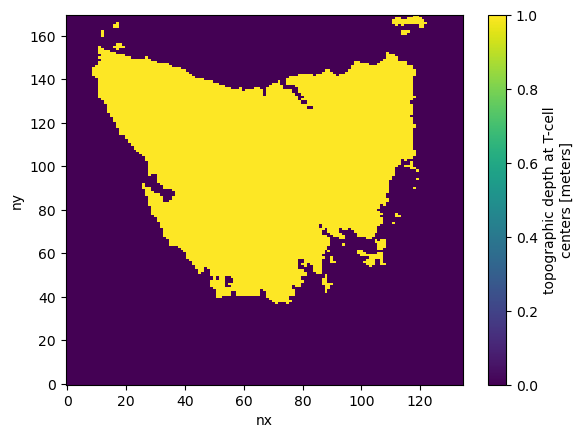

In [ ]:
topog = xr.open_dataset("/home/149/ab8992/mom6_rundirs/tassie_30th/inputdir/holy_topog.nc")
binary = topog.depth.where(topog.depth == 0 , 1).isel(ny = slice(150,320),nx = slice(40,175))
binary = np.abs(binary - 1)
binary.plot()

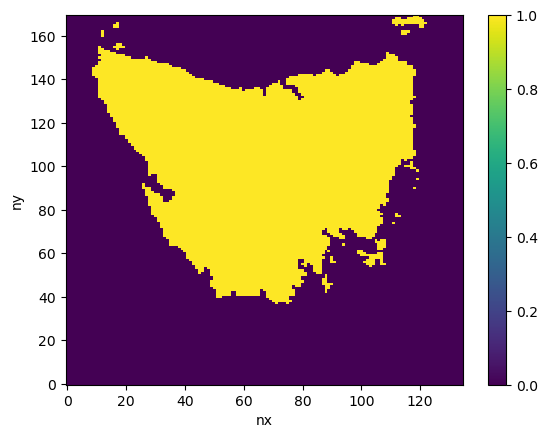

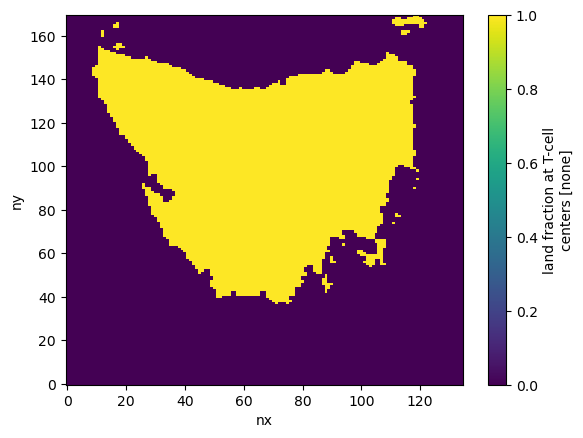

In [3]:
from scipy.ndimage import binary_fill_holes
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
topog = xr.open_dataset("/home/149/ab8992/mom6_rundirs/tassie_30th/inputdir/holy_topog.nc")
deseas = xr.open_dataset("/home/149/ab8992/mom6_rundirs/tassie_30th/inputdir/land_mask.nc")

def compare(tt,deseas,xrange,yrange):

    fig,ax = plt.subplots(1,2,figsize = (10,10))

    tt.isel(ny = slice(yrange[0],yrange[1]),nx=slice(xrange[0],xrange[1])).plot(ax = ax[0],add_colorbar = False)
    ax[0].set_title("mine")
    deseas.isel(ny = slice(yrange[0],yrange[1]),nx=slice(xrange[0],xrange[1])).mask.plot(ax = ax[1],add_colorbar = False)
    ax[1].set_title("deseas")

deseas = deseas.where(deseas == 0 , 1).isel(ny = slice(150,320),nx = slice(40,175))
binary = topog.depth.where(topog.depth == 0 , 1).isel(ny = slice(150,320),nx = slice(40,175))
binary = np.abs(binary - 1)
filled = xr.DataArray(
    data = binary_fill_holes(binary.values),
    dims = ["ny","nx"]
)

filled.plot()
plt.figure()
deseas.mask.plot()

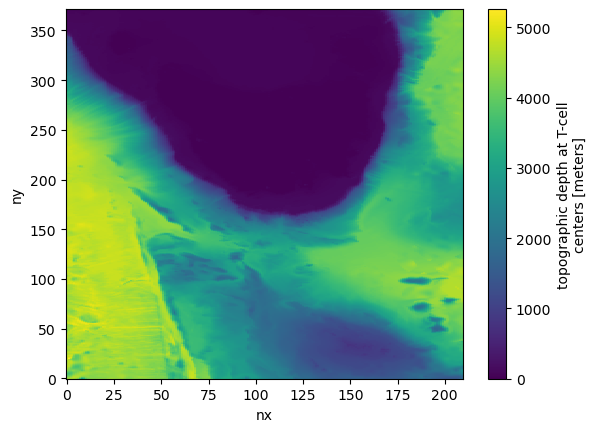

In [34]:
topog = xr.open_dataset("/home/149/ab8992/mom6_rundirs/tassie_30th/inputdir/holy_topog.nc")
topog.depth.plot()

## Design a ufunc that fills in channels that are 1 grid cell wide

<xarray.DataArray 'depth' ()>
array(True)
<xarray.DataArray 'depth' ()>
array(True)
<xarray.DataArray 'depth' ()>
array(True)
<xarray.DataArray 'depth' ()>
array(True)
<xarray.DataArray 'depth' ()>
array(False)


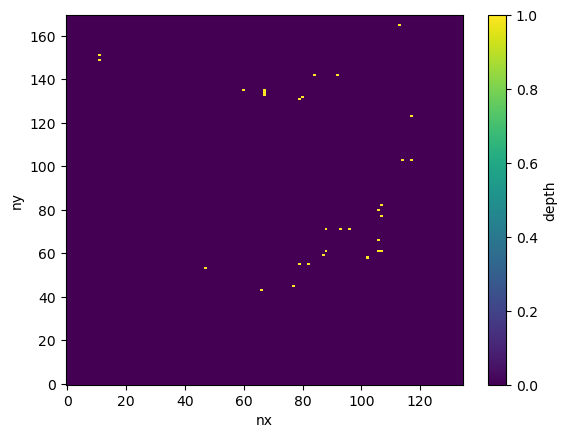

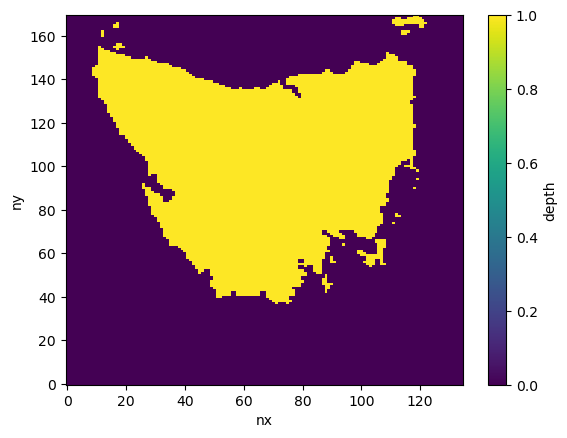

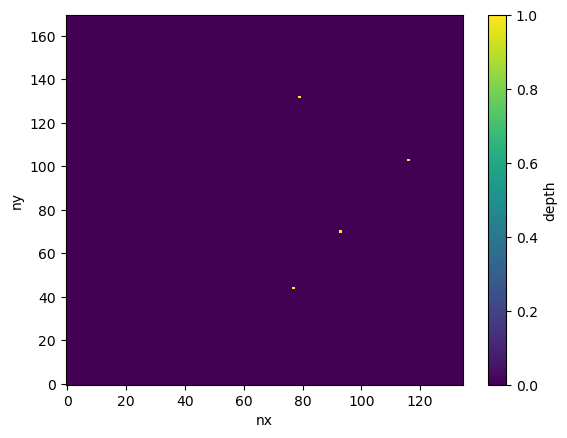

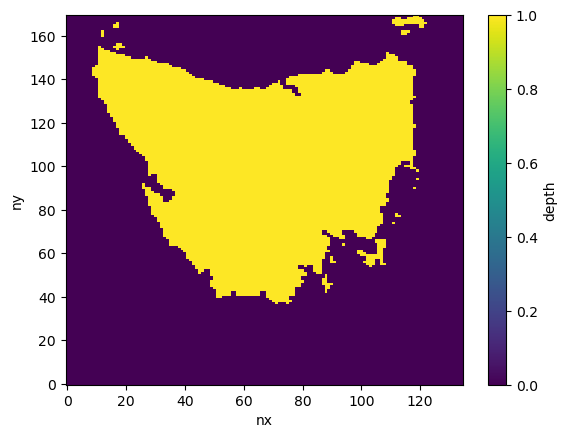

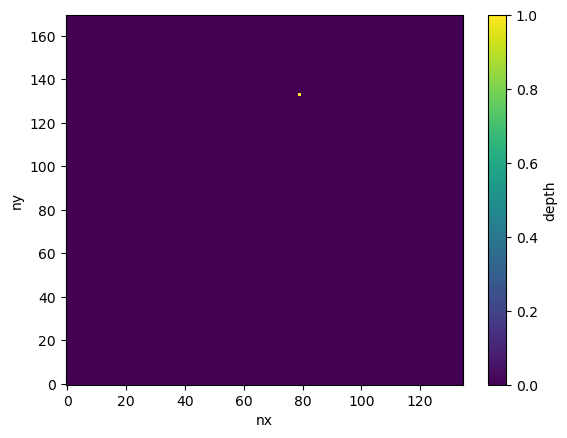

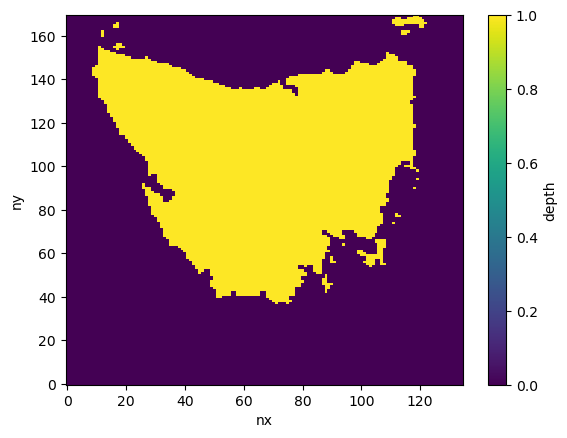

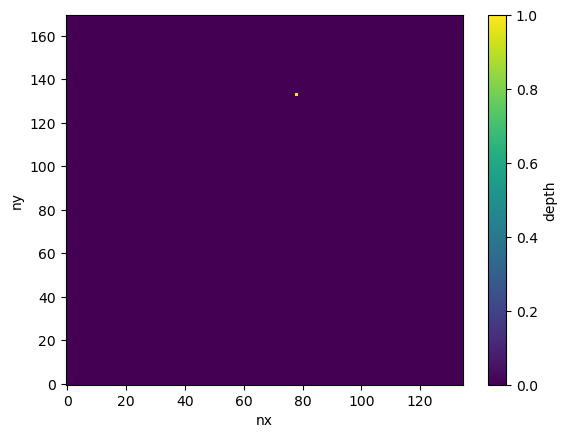

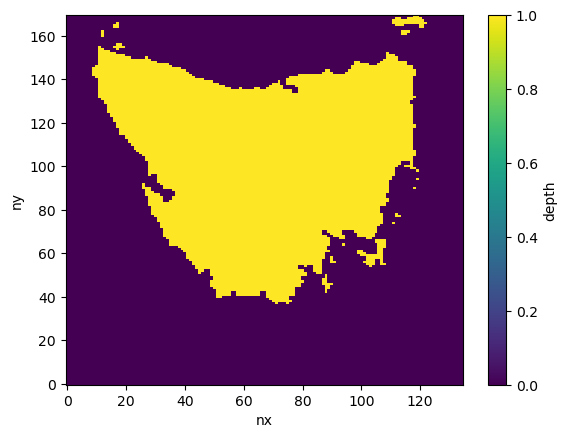

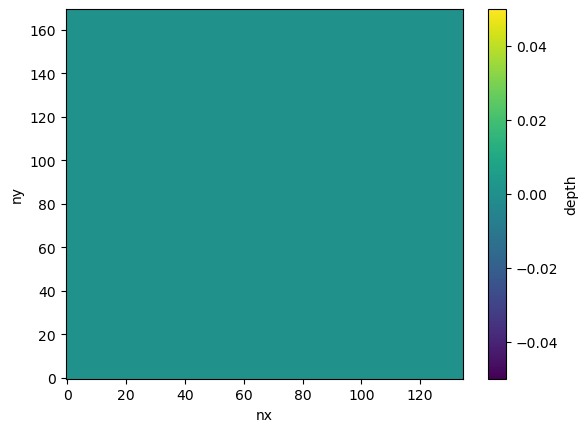

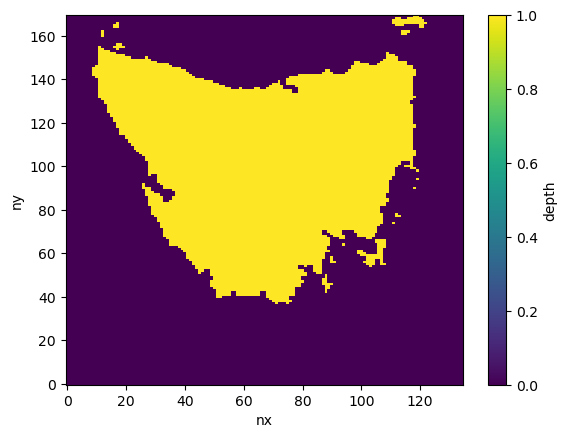

<Figure size 640x480 with 0 Axes>

In [26]:
tt = binary.copy(deep = True)
changed = True

forward = True
diagonal = False
# for i in range(10):
while changed == True:
    tt[:,:] = binary_fill_holes(tt.data)
    invert = np.abs(tt - 1)

    mask = xr.where(invert * (tt.shift(nx = 1) + tt.shift(nx = -1)) == 2,1,0)
    mask += xr.where(invert * (tt.shift(ny = 1) + tt.shift(ny = -1)) == 2,1,0)

    if diagonal == True:
        ## Diagonal channels 
        if forward == True:
            ## horizontal channels
            mask += xr.where((invert * invert.shift(nx = 1)) * (tt.shift({"nx":1,"ny":1}) + tt.shift({"ny":-1})) == 2,1,0) ## up right & below
            mask += xr.where((invert * invert.shift(nx = 1)) * (tt.shift({"nx":1,"ny":-1}) + tt.shift({"ny":1})) == 2,1,0) ## down right & above
            ## Vertical channels
            mask += xr.where((invert * invert.shift(ny = 1)) * (tt.shift({"nx":1,"ny":1}) + tt.shift({"nx":-1})) == 2,1,0) ## up right & left
            mask += xr.where((invert * invert.shift(ny = 1)) * (tt.shift({"nx":-1,"ny":1}) + tt.shift({"nx":1})) == 2,1,0) ## up left & right

        if forward == False:
            ## Horizontal channels
            mask += xr.where((invert * invert.shift(nx = -1)) * (tt.shift({"nx":-1,"ny":1}) + tt.shift({"ny":-1})) == 2,1,0) ## up left & below
            mask += xr.where((invert * invert.shift(nx = -1)) * (tt.shift({"nx":-1,"ny":-1}) + tt.shift({"ny":1})) == 2,1,0) ## down left & above
            ## Vertical channels
            mask += xr.where((invert * invert.shift(ny = -1)) * (tt.shift({"nx":1,"ny":-1}) + tt.shift({"nx":-1})) == 2,1,0) ## down right & left
            mask += xr.where((invert * invert.shift(ny = -1)) * (tt.shift({"nx":-1,"ny":-1}) + tt.shift({"nx":1})) == 2,1,0) ## down left & right

        forward = False

    mask = xr.where(mask > 0 , 1,0)
    mask.plot()
    plt.figure()
    changed = np.max(mask) == 1
    tt += mask

    tt.plot()
    plt.figure()
    print(changed)




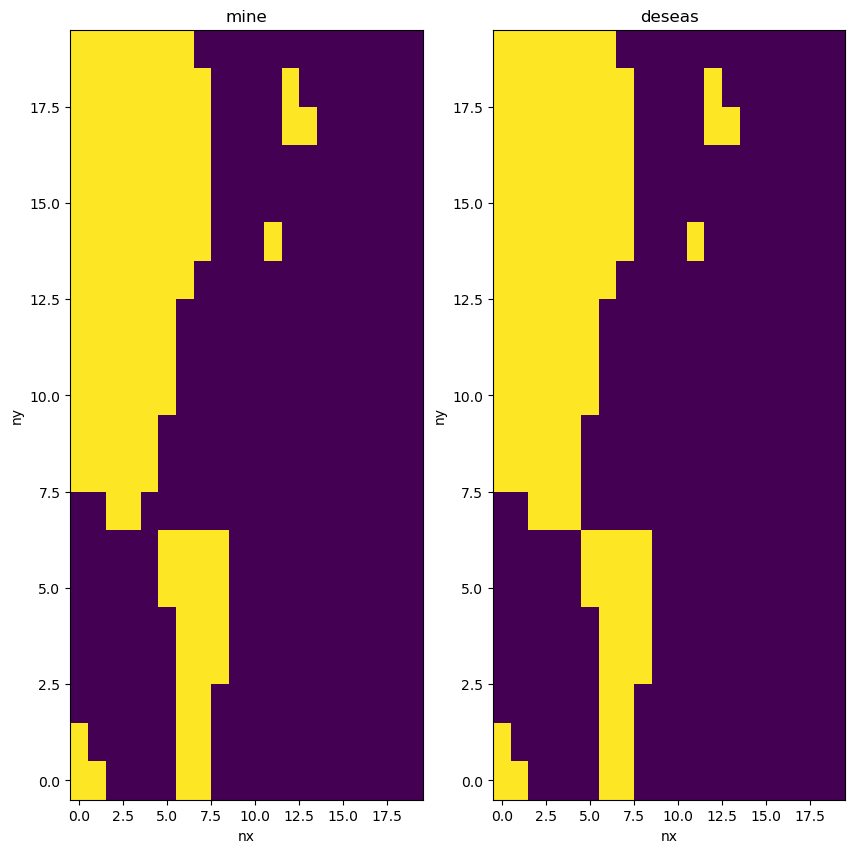

In [27]:

(compare(tt,deseas,[100,120],[60,80])
)

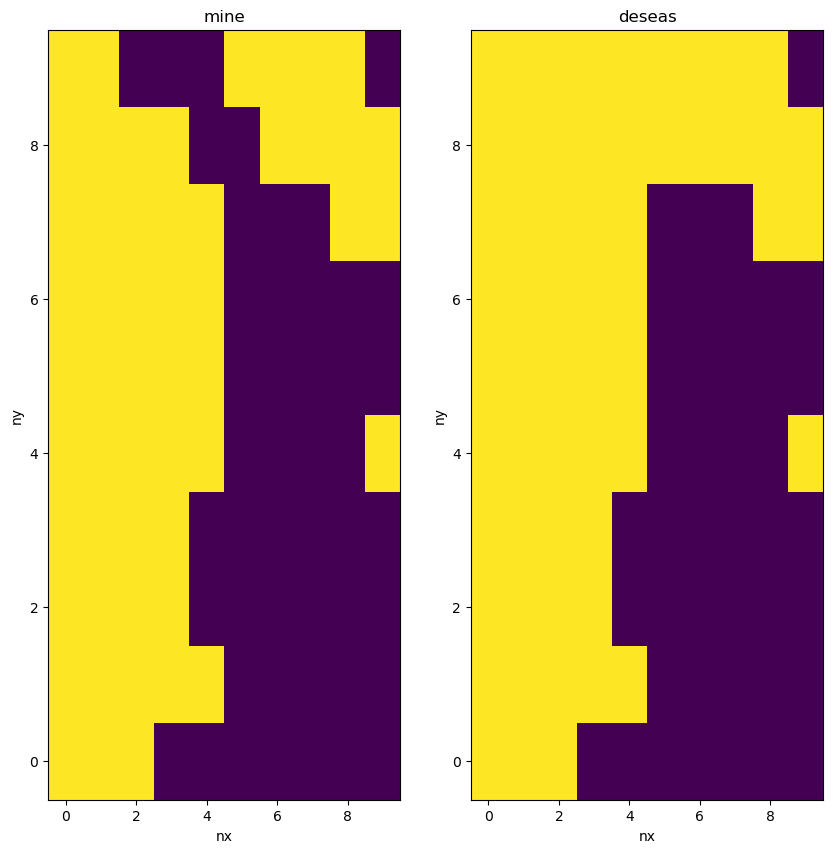

In [28]:

(compare(tt,deseas,[85,95],[60,70])
)

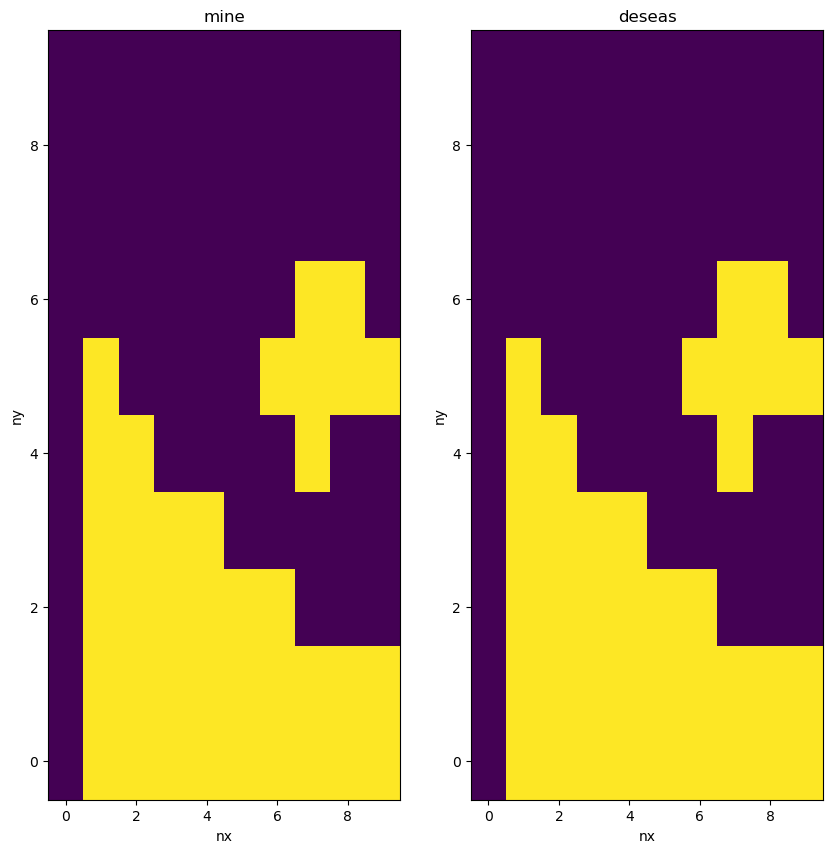

In [29]:
(compare(tt,deseas,[10,20],[150,160])
)

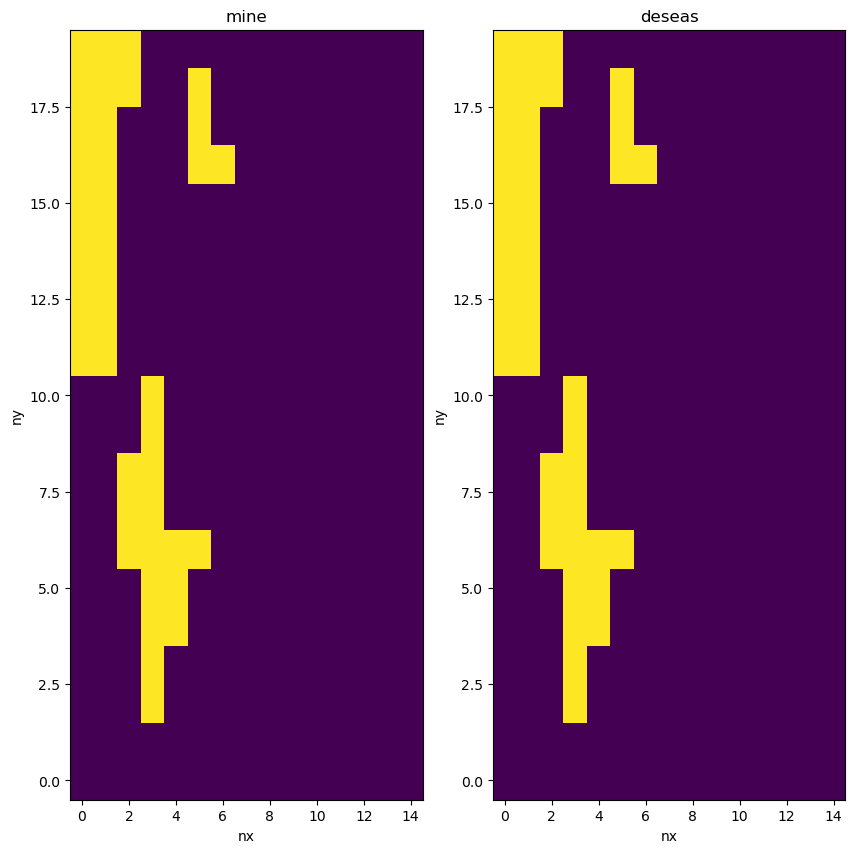

In [30]:
(compare(tt,deseas,[85,100],[40,60])
)

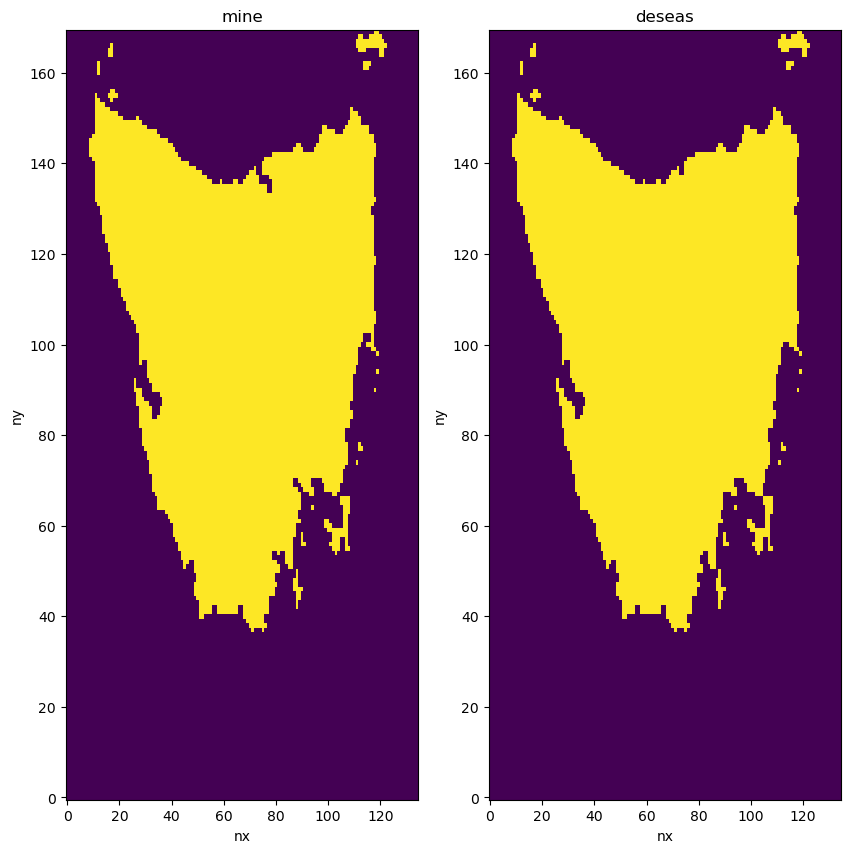

In [31]:
compare(tt,deseas,[None,None],[None,None])